# CNN_pipeline.
Код реализует алгоритм симуляции торгов. Формирует предсказания, используя уже обученные модели ChP_c, ChP_r и TF, и оценивает их качество. При этом, если на вход для получения предсказаний подаются сырые данные, к ним применяются процедуры преобработки и формирования признаков.

In [17]:
#загрузка нужных библиотек (встроенные библиотеки Анаконды)
import pandas as pd
import numpy as np
import os
import time
import datetime as dt
from __future__ import print_function
from __future__ import division
from sklearn import metrics
import itertools
from scipy import stats

In [18]:
import matplotlib
matplotlib.use('agg')#этот бэкэнд нужен чтобы переводить картинки сразу в RGB-матрицу
from matplotlib import pyplot as plt #Источник pip install mpl_finance - раньше было частью matplotlib
from mpl_finance import candlestick2_ohlc#модуль для рисования графиков со свечами

In [19]:
#библиотека для работы со сверточными сетями
import cntk as C #Источник: https://docs.microsoft.com/en-us/cognitive-toolkit/Setup-Windows-Python
#для работы CNTK требуется доустановка MKL-DNN - https://anaconda.org/anaconda/mkl-dnn
#прогресс бар для контроля исполнения кода (актуально для длинных расчетов)
import progressbar as pbar# Источник: https://anaconda.org/conda-forge/progressbar2
import trend_functions as trd #может потребоваться установка xgboost - https://www.lfd.uci.edu/~gohlke/pythonlibs/#xgboost

In [20]:
import warnings;warnings.simplefilter('once')


## Логика Pipeline

Первой запускается модель (ChP_с), которая отвечает за определение наличия точек смены тенденции в окне шириной n_days (например,n_days=25 соответствует примерно 5 неделям, а n_days =75-15ти). Для снижения времени расчетов окна берутся с шагом skip (например, skip= 5 дней), что дает некритичную погрешность.  Если модель ChP_c определяет наличие смены тенденции в окне (ChP_c_pred=1), подключается модель ChP_r, для определения того, где именно началась последняя тенденция (win_srt). Если же значение ChP_c_pred=0 (не было смены тенденции), то точкой начала тенденции (win_srt) является значение, опреденное по предыдущему окну (или же начало файла данных). Концом тенденции (win_end) по умолчанию считается дата, на которую запускается модель ChP_c. Котировки акций, взятые за даты между win_srt и win_end передаются в модель TF,которая определяется тип тенденции (восходящий, нисходящий тренд или флэт) - так опредлеляется значение ScoredNewTypeBool на текущую дату. Оно дейстствует следующие skip дней, то есть до очередного запуска расчета.  Для Pipeline финальной является оценка, которую дала именно модель TF, поэтому после полной обработки определяются фактические точки смены тенденции ScoredNewTrigger. Промежуточные значения (точки win_start) сохраняются в переменной ScoredNewTrigger_tmp. 

Код по-разному работает для случаев, когда на вход подаются размеченные или неразмеченные данные, а также в зависимости от ряда других дополнительных параметров, которые устанавливаюся перед началом расчета.

Pipeline требует предварительной подготовки данных с помощью ряда вспомогательных функций, приведенных ниже, а также сохраненных в модуле trend_functions.

## Вспомогательные функции

In [21]:
def CNN_process_and_save(input_set,Trigger_col,dpi,n_days,skip,filename,norm):
    CNN_data,CNN_images,CNN_labels,CNN_im_shape,CNN_lb_shape =CNN_changes_preprocess_op4_fin(
                                                                    input_set,Trigger_col,dpi,n_days,skip)
    CNN_trans=transpose_data(CNN_images,CNN_labels)
    savetxt_chP_op4_fin(os.path.join(path, filename), CNN_trans, CNN_lb_shape,norm)

In [22]:
def restore_prices_volumes (input_set, logarithm):
    ##
    #В сохраненном файле вместо значений  Open,High,Low находятся их отношения к цене закрытия (логарифмированной или нет)
    #Чтобы восстановить исходные значения мы делаем обратное преобразование
    #Этого можно избежать, если изначально работать с сырыми данными, а не с сохранненным файлом
    num_cols_orig=["Open_orig","High_orig","Low_orig","Close_orig", "Volume_orig"]
    num_cols=["Open","High","Low","Close", "Volume"]
    if logarithm: #для моделей, где использована разность логарифмов, а не частное
        input_set[num_cols_orig]=np.exp(input_set[num_cols])
    else:    
        input_set[num_cols_orig]=input_set[num_cols]
    
    input_set["Open_orig"] =input_set["Open_orig"]*input_set["Close_orig"]
    input_set["High_orig"] =input_set["High_orig"]*input_set["Close_orig"]
    input_set["Low_orig"] = input_set["Low_orig"]*input_set["Close_orig"]
    
    if logarithm: #если далее надо вернуться к логарифмам
        input_set[num_cols_orig]= np.log(input_set[num_cols_orig])
    input_set.drop(columns=num_cols, inplace=True)
    input_set.rename(columns={"Open_orig": "Open", "High_orig": "High",
                             "Low_orig":"Low","Close_orig":"Close", "Volume_orig":"Volume"},
                    inplace=True)
    return input_set

In [23]:
def ctf_parser (fname, headers):
    parsed_data={}
    with open(fname,'r') as f:
        fst_line=f.readline()
        fst_columns=fst_line.strip().split('|')
        fst_headers=[fst_columns[i].split(" ")[0] for i in range(len(fst_columns))]
        indices=[fst_headers.index(h) for h in headers]
        line_id=0
    f=open(fname,'r')
    for line in f:
        columns=line.strip().split('|')
        for ix in indices:
            ix_header=columns[ix].split(" ")[0]
            ix_data=columns[ix].split(" ")[1:]
            parsed_data[(ix_header, line_id)]=np.array(ix_data).flatten()
        line_id+=1
    f.close()
    return parsed_data, line_id

In [24]:
def ctf_parser_light(fname, header):
    parsed_data=[]
    with open(fname,'r') as f:
        fst_line=f.readline()
        fst_columns=fst_line.strip().split('|')
        fst_headers=[fst_columns[i].split(" ")[0] for i in range(len(fst_columns))]
        ix=fst_headers.index(header)
    f=open(fname,'r')
    for line in f:
        columns=line.strip().split('|')
        ix_data=columns[ix].split(" ")[1:]
        parsed_data.append(np.array(ix_data).flatten())
    f.close()
    return np.array(parsed_data)

In [25]:
def get_picture (price_set,dpi):
    #отрисовываем картинку для каждого среза
    fig, ax = plt.subplots(dpi=dpi)# выбираем нужное разрешение
    plt.axis('off')#отключаем оси
    fig.tight_layout(pad=0)#убираем рамку
    #создаем график из свечей
    candlestick2_ohlc(ax,price_set["Open"],price_set["High"],price_set["Low"],price_set["Close"],
                                      colorup='b', colordown='r',width=1,alpha=1)#Цвета такие, чтобы в RGB было больше нулей
    fig.canvas.draw()#отрисовываем картинку
    #print(fig.canvas.get_width_height())

    #получаем из картинки матрицу RGB в виде вектора
    image_flat = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    #сохраняем размеры матрицы для картинки
    im_shape=fig.canvas.get_width_height()[::-1] + (3,) #кортеж: высота,ширина, количество каналов
    image=image_flat.reshape(im_shape)#превращаем в массив размером (height,width,3)
    #сохраняем картинку в папку (необязательно, но так можно видеть, что вышло)
#   plt.savefig(os.path.join(path,"change_images_op2_"+str(dpi)+"dpi_"+str(n_days)+"d",f+"_"+date+ln+str(CNN_labels[(f,date)])+'.png'), 
#       dpi=dpi,bbox_inches='tight',pad_inches=0,transparent=True)
    plt.close(fig)
    return image_flat,im_shape,image

In [26]:
def CNN_changes_preprocess_op4_fin(input_set,Trigger_col,dpi,n_days,mode="OUT", skip=1):
    
    #Принимает на вход массив котировок (input_set), в колонке Trigger_col содержится метка о смене тенденции,
    #dpi - разрешение, с которым сохраняются картинки
    #Возвращает CNN_data - массив из оцифрованных картинок с метками
    #CNN_images - только оцифрованные картинки,CNN_labels - только метки,
    #CNN_im_shape - размер одной картинки в формате "высота,ширина, количество каналов"
    #CNN_lb_shape- размер одной метки
    
    input_set.reset_index(drop=True,inplace=True)
    matplotlib.pyplot.close('all')
    
    CNN_data={}
    CNN_images={}
    CNN_labels={}
    
  
    CNN_im_shape=(0,0,0)
    CNN_lb_shape=1
    trigger="-"
    #каждая метка содержит 1 значение - была или нет смена тенденции
    srange=list(input_set['Source'].drop_duplicates())
    print ("Started processing images from ", str(len(srange)), " sources")
    for s in srange:#для каждого источника 
        stock_set=input_set[input_set['Source']==s]#выбрали источник
        frange=list(stock_set['Stockname'].drop_duplicates())#составляем список акций в этом источнике
        bar = pbar.ProgressBar(max_value=len(frange)).start() # Создаём новый progress bar
        t=0

        for f in frange:# перебираем все файлы
            TrendNew=stock_set[stock_set["Stockname"]==f]
            start_ix=TrendNew.index[0]
            for start_ix in TrendNew.index[:-(n_days-1):skip]:
                ChangeWin=TrendNew.loc[start_ix:start_ix+n_days-1]
                date_srt=str(ChangeWin.loc[start_ix, "Date"].date())
                date_end=str(ChangeWin.loc[start_ix+n_days-1, "Date"].date())
                
                #заполняем метки
                if mode=="OUT":
                    trigger=int(np.max(ChangeWin[Trigger_col]))# 1 если была смена тенденции, 0 -если нет
                    CNN_labels[(s,f,date_srt,date_end)]=trigger
                #отрисовываем картинку для каждого среза
                image_flat,CNN_im_shape,image=get_picture(ChangeWin,dpi)
                
                #сохраняем в словарь картинку в виде матрицы с заданным размером
                CNN_images[(s,f,date_srt,date_end)]= image

                #сохраняем в словарь данные - плоская картинка + метка 
                CNN_data[(s,f,date_srt,date_end)]=np.hstack([image_flat,trigger])              

            
            t+=1
            bar.update(t)
        bar.finish()
    return CNN_data,CNN_images,CNN_labels,CNN_im_shape,CNN_lb_shape

In [27]:
def transpose_data(input_dic, output_dic):
    
    #Получает на вход два словаря  с инпутами  и аутпутами, соответсвующими одинаковым ключам
    #В словарях для каждого ключа сохранена матрицам определенных размеров
    #В этих матрицах надо инвертировать порядок измерений (для соответсвия требованиям СNTK), 
    # а потом уплощить и сохранить в новый словарь
    
    print ("Started transposing data")
    data_trans_flat={}
    for key in input_dic:
        input_trans_flat=np.transpose(input_dic[key]).flatten()
        output_trans_flat=np.transpose(output_dic[key]).flatten()
        data_trans_flat[key]=np.hstack((input_trans_flat,output_trans_flat))
    return data_trans_flat

In [28]:
# Save the data files into a format compatible with CNTK text reader (формат CTF)
# Источник - Майкрософт +модификации
def savetxt_chP_op4_fin(filename, data_dic, label_len, norm=False):
    dir = os.path.dirname(filename)

    if not os.path.exists(dir):
        os.makedirs(dir)

    if not os.path.isfile(filename):
        print("Saving", filename )
        
        with open(filename, 'w') as f:
            bar = pbar.ProgressBar(max_value=len(data_dic)).start() # Создаём новый progress bar
            t=0
            for key in data_dic:
                row=data_dic[key]
                row_str = row.astype(str)
                label_str = ' '.join(row_str[-label_len:])#последние label_len элемента в строке -метка
                if norm: 
                    feature_str= ' '.join((row[:-label_len]//255).astype(str))#все: кроме последних с разделителем " "
                else:feature_str = ' '.join(row_str[:-label_len])#все: кроме последних с разделителем " " 
                key_str=' '.join(key)
                f.write('|keys {}|labels {}|features {}\n'.format(key_str, label_str, feature_str))
                t+=1
                bar.update(t)
            bar.finish()
    else:
        print("File already exists", filename)

In [29]:
def create_mask (input_set, source, stockname, date1 ,date2=None):
    
    mask_source=input_set['Source']==source
    mask_stock=input_set['Stockname']==stockname
    if date2==None:
        mask_dates=input_set['Date']==date1
    else:
        mask_date1=input_set['Date']>date1
        mask_date2=input_set['Date']<=date2
        mask_dates=mask_date1&mask_date2
    mask=mask_source&mask_stock&mask_dates
    return mask

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    return cm

In [31]:
def show_cnf_matrix(y_true, y_pred,class_names,labels=None):
    %matplotlib inline
    # Compute confusion matrix
    cnf_matrix = metrics.confusion_matrix(y_true,y_pred,labels)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    cm=plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    cm_norm=plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()
    return cm, cm_norm


## Запуск алгоритма симуляции торгов


In [32]:
#определяем источник данных
#path=os.path.join('C:/', 'Users', 'elzolotareva','Desktop','Alfa-Capital-VM')#виртуальная машина
path=os.path.abspath(os.curdir)#текущая папка
# Определяем исходные данные для моделей
saveas="121017cnn_bb" 
# определяем, надо ли логарифмировать данные для модели
logarithm=True
# если да, то прибавлем "_ln_" к метке saveas
ln="_ln_"if logarithm else ""
saveas=ln+saveas

#Определяем параметры расчета
mode="OUT"#OUT означает, что в файле есть ground truth и с ней надо сравнить
clean=True# True означает, что мы будет работать с файлом, где устранены разногласия экспертов (для размеченных)
test_only=True #True означает, что для экономии времени мы размечаем только тестовую выборку
data_status=3
#3 - есть готовые файлы как в формате CTF, так и CSV
#2 - есть подготовленый файл CSV, но нет CTF
#1 - есть подготовленные файлы с предыдущих этапов, требующие обработки
#0 - сырые данные, их нужно предварительно очистить и подготовить
lag=5 #на случай, если попадутся необработанные данные, в которых необходимо будет выполнить move_triggers

dpi_ChP=10#Разрешение картинок для моделей, оценивающих наличие и место смены тенденции
dpi_TF=10#Разрешение картинок для модели, определяющей тип тенденции

ChP_shape=(int(dpi_ChP/10*48),int(dpi_ChP/10*64),3)#Размер матрицы признаков для моделей ChP
TF_shape=(int(dpi_TF/10*48),int(dpi_TF/10*64),3)#Размер матрицы признаков для модели TF
ChP_lb = 1#размерность пространства меток для моделей ChP
TF_lb = 3#размерность пространства меток для модели TF

n_days=75
#n_days=25 #Размер среза данных для оценки.
#Предпочительно, чтобы он совпадал с показателем n_days, 
#по которому обучены модели ChP. Иначе результат не предсказуем.
skip=5 #Шаг - влияет на объем данных и скорость работы. 

# Если модели обучены на нормированных данных, то и давать им надо нормированные
ChP_norm=True 
TF_norm=True
norm_str="_norm" if ChP_norm else ""

ChP_с_id="6"# id модели ChP-классификатора для 75 дневок
#ChP_с_id="4"# id модели ChP-классификатора для 25 дневок

ChP_r_id="13"# id модели ChP-регрессии для 75 дневок
#ChP_r_id="15"# id модели ChP-регрессии для 25 дневок

TF_id="19"# id модели TF

# название файлов, в которых сохранены модели ChP и TF
ChP_c_file="CNN_ChP_trans_op4_6.model"
#ChP_c_file="CNN_ChP_trans_op4_4.model"

ChP_r_file="CNN_ChP_trans_op3_13.model"
#ChP_r_file="CNN_ChP_trans_op3_15.model"

TF_file="CNN_19_trans.model"

    
tresh=0.5 #регулируем количество ложных срабатываний

d_split=dt.datetime.strptime("2014-10-17","%Y-%m-%d")#для моделей, обученных на всех данных(Барк,Брагин)
d_spl="_up_to_"+str(d_split.day)+"-"+ str(d_split.month)+"-"+str(d_split.year)

if data_status==0: #  указываем источник (папку) и расширение для сырых данных
    raw_data_source = ["IN"] #папка(папки), в которой лежат сырые данные
    #extention="csv"#расширение, в котором сохранены исходные данные  - csv или xlsx
    extention="xlsx"#расширение, в котором сохранены исходные данные  - csv или xlsx
    saveas="_".join(raw_data_source)
elif data_status==1:    
#указываем название файлов, где лежат предварительно обработанные данные
    NewAllChangePoints_file= "NewAllChangePoints_ln_121017v2BB.csv" #файл с массивом NewAllChangePoints
    CleanPoints_file="CleanPoints_ln_121017v2BB.csv"
else:
    CNN_Trends_file="CNN_Trends_Triggers"+saveas+".csv"
    CleanCNN_Trends_file="CNN_Trends_Triggers_clean" +saveas+".csv"
    if data_status==3:
        #указываем названия файлов в формате CTF, пригодном для CNTK
        #test_file_name ="Test_ChPop4_trans_keys"+str(dpi_ChP)+"dpi_"+str(n_days)+"-"+str(skip)+"d_"+"clean"+norm_str+".txt"
        eval_file_name ="Test_ChPop4_trans_keys10dpi_75-5d_clean_norm_v2.txt"
        #eval_file_name ="Test_ChPop4_trans_keys10dpi_25-5d_clean_norm_v2.txt"
# название пайплайна
cl="clean" if clean else ""
pipe_name =mode+"_ChPс"+ChP_с_id+"_ChPr"+ChP_r_id+"_TF"+TF_id +ln+cl+d_spl+"_tresh="+str(tresh)+saveas
pipe_file_name=os.path.join(path, "CNNpipe_"+pipe_name+"_")#имя, под которым будут сохраняться результаты

In [ ]:
%%time

CNN_relevant_cols=[]
indep_cols=[]
key=["Source","Stockname","Date"]
CNN_key=["Source","Stockname","Date_srt", "Date_end"]
num_cols=["Open","High","Low","Close", "Volume"]
indep_cols.extend(key)
indep_cols.extend(num_cols)
label_cols=["NewTypeBool_sign",'NewTrigger']
CNN_relevant_cols.extend(indep_cols)
if mode=="OUT":CNN_relevant_cols.extend(label_cols)

CTF_columns=["keys","features"]
if mode=="OUT":CTF_columns.extend(["labels"])
    
#Загружаем данные
if data_status==0:
    #Обрабатываем сырые данные
    new_data =pd.DataFrame()
    for source in raw_data_source:
        new_data_tmp=trd.join_files(os.path.join(path, source),"",extention=extention, mode=mode,make_ln=logarithm)
        new_data=pd.concat([new_data,new_data_tmp])
    new_data=new_data.reset_index(drop=True)
    
    #Округляем, чтобы исключить технические ошибки
    new_data[num_cols]= new_data[num_cols].round(10)
    # список колонок, которые содержат независимые (от эксперта) сведения о состоянии рынка
    
    if trd.check_for_unique_keys(key,indep_cols,new_data):
        CNN_trends = new_data
        if mode=="OUT": 
            #заменяем "серые зоны" на флэт
            CNN_Trends=trd.UnknownToFlat(CNN_Trends)
            #определеяем точки перелома тендеции
            CNN_Trends=trd.fill_trigger_by_idselect(CNN_trends)
            CNN_Trends=trd.add_direction(CNN_Trends,"IDselect_tmp", "NewTypeBool")
            CNN_Trends=trd.move_triggers(CNN_Trends,lag,False)
            if clean:
                CleanCNN_Trends=trd.clean_changepoints (CNN_Trends,type_col="NewTypeBool_sign")
                CleanCNN_Trends=trd.fill_idselect(CleanCNN_Trends,"IDselect","NewTrigger")
                CleanCNN_Trends=trd.move_triggers (CleanCNN_Trends,lag,True)
                CleanCNN_Trends.to_csv(os.path.join(path,"CNN_Trends_Triggers_clean" +saveas+".csv"),sep = ',', index = False,header=1,encoding='cp1251')
        CNN_Trends.to_csv(os.path.join(path,"CNN_Trends_Triggers" +saveas+".csv"),sep = ',', index = False,header=1,encoding='cp1251')   
elif data_status==1:
    #Загружаем подготовленные исходные данные из файла 
    NewAllChangePoints=pd.read_csv(os.path.join(path, NewAllChangePoints_file), header=0, sep=',',encoding='cp1251')
    NewAllChangePoints=restore_prices_volumes(NewAllChangePoints, logarithm)
    cols_to_copy=['File_id']
    if mode=="OUT":cols_to_copy.extend(["IDselect_tmp", "Username"])
    cols_to_copy.extend(CNN_relevant_cols)
    CNN_Trends=NewAllChangePoints[cols_to_copy]
    CNN_Trends.to_csv(os.path.join(path,"CNN_Trends_Triggers" +saveas+".csv"),sep = ',', index = False,header=1,encoding='cp1251')   
    if clean:
        CleanPoints= pd.read_csv(os.path.join(path, CleanPoints_file), header=0, sep=',',encoding='cp1251')
        CleanPoints= restore_prices_volumes(CleanPoints, logarithm)
        cols_to_copy=[]
        if mode=="OUT":cols_to_copy.extend(["IDselect"])
        cols_to_copy.extend(CNN_relevant_cols)
        CleanCNN_Trends=CleanPoints[cols_to_copy]
        CleanCNN_Trends.to_csv(os.path.join(path,"CNN_Trends_Triggers_clean" +saveas+".csv"),sep = ',', index = False,header=1,encoding='cp1251')
else:
    CNN_Trends=pd.read_csv(os.path.join(path, CNN_Trends_file), header=0, sep=',',encoding='cp1251')
    if clean:CleanCNN_Trends=pd.read_csv(os.path.join(path, CleanCNN_Trends_file), header=0, sep=',',encoding='cp1251')
        
#приводим даты к формату даты, чтобы можно было сортировать по дате
CNN_Trends["Date"]=pd.to_datetime(CNN_Trends["Date"], format = "%Y/%m/%d")
CNN_Trends.sort_values(["File_id","Date"], ascending=True, inplace=True)
if clean:
    CleanCNN_Trends["Date"]=pd.to_datetime(CleanCNN_Trends["Date"], format = "%Y/%m/%d")
    CleanCNN_Trends.sort_values(['Source', 'Stockname',"Date"], ascending=True, inplace=True)

if data_status<3:
    #далее можно работать с исходным файлом или с очищенным (с усредненными оценками)
    CTF_base=CleanCNN_Trends if clean else CNN_Trends
    eval_set=CTF_base[CTF_base["Date"]>d_split] if test_only else CTF_base
    CNN_process_and_save(eval_set,"NewTrigger",dpi,n_days,skip,eval_file_name,ChP_norm)
    
CTF_data, eval_size =ctf_parser(os.path.join(path,eval_file_name), CTF_columns)

## 1 и 2. Шаг первый и второй:

1. определяем, есть ли в срезе данных точка смены тенденции (модель ChP_c), и если да, то где она (модель СhP_r)

2. определяем текущую тенденцию в выделенном окне (модель TF)

In [ ]:
#далее можно работать с исходным файлом или с очищенным (с усредненными оценками)
AllChangePoints=CleanCNN_Trends if clean else CNN_Trends

In [ ]:
%%time
#Проверяем ключ на уникальность
trd.check_for_unique_keys(key,indep_cols,AllChangePoints)
#Проверяем ключ на уникальность
trd.check_for_unique_keys(key,indep_cols,CNN_Trends)

In [ ]:
%%time
#Удаляем строки, в которых есть дубликаты
print (AllChangePoints.shape, "original")
SubAllChangePoints=AllChangePoints.drop_duplicates(subset=indep_cols)#если загружен clean, то дубликатов не должно быть
print (SubAllChangePoints.shape, "relevant, no duplicates")

In [ ]:
# Фиксируем параметры, отвечающие за "случайность" для возможности воспроизведения результата
np.random.seed(0)
C.cntk_py.set_fixed_random_seed(1)
C.cntk_py.force_deterministic_algorithms()

# Определяем размерность данных
ChP_dim_model = ChP_shape [::-1]  # images are 384 (image width) x 288 (image height) with 3 channel of color (RGB) 
TF_dim_model = TF_shape [::-1]
#ChP_dim = int(np.prod(ChP_shape)) # 

In [ ]:
saved_ChP_c = C.Function.load(os.path.join(path, ChP_c_file))
saved_ChP_r = C.Function.load(os.path.join(path, ChP_r_file))
saved_TF = C.Function.load(os.path.join(path, TF_file))

In [ ]:
ChP_keys=np.array([CTF_data["keys",i] for i in range(eval_size)])
#Важно,чтобы индекс фрейма ChP_keys соответсвовал номеру записи в словаре с features
ChP_keys=pd.DataFrame(ChP_keys,columns=CNN_key,index=range(eval_size))
ChP_keys["Date_srt"]=pd.to_datetime(ChP_keys["Date_srt"], format = "%Y-%m-%d")
ChP_keys["Date_end"]=pd.to_datetime(ChP_keys["Date_end"], format = "%Y-%m-%d")
print (ChP_keys.shape, "original")
ChP_keys.drop_duplicates(inplace=True)#на тот случай, если CTF-датасет содержит метки разных экспертов (дублирующиеся features)
print (ChP_keys.shape, "no duplicates")

In [ ]:
TF_predictions=pd.DataFrame(columns=["Source", "Stockname","Win_srt","Win_end","Valid_till", "ScoredNewTypeBool"])
ChP_predictions=pd.DataFrame(columns=["Source", "Stockname","Date_srt","Date_end","Trigger_score", "Trigger_pred","Position_pred"])

mappedSubAllChangePoints=SubAllChangePoints.copy()
bar = pbar.ProgressBar(max_value=ChP_keys.shape[0]).start() # Создаём новый progress bar
t=0
srange=list(ChP_keys['Source'].drop_duplicates())
for s in srange:#для каждого источника 
    stock_set=ChP_keys[ChP_keys['Source']==s]#выбрали источник
    frange=list(stock_set['Stockname'].drop_duplicates())#составляем список акций в этом источнике
    for f in frange:# перебираем все файлы(акции)
        TrendNew=stock_set[stock_set["Stockname"]==f]
        win_srt=ChP_keys.loc[TrendNew.index[0], "Date_srt"]
        #print(s,f,TrendNew.index)
        for i in TrendNew.index:
            win_end=ChP_keys.loc[i, "Date_end"]
            if i!=TrendNew.index[0]:
                TF_predictions.loc[i_last,"Valid_till"]=win_end
                d1=TF_predictions.loc[i_last,"Win_end"]
                d2=TF_predictions.loc[i_last,"Valid_till"]
                mask_valid=create_mask(mappedSubAllChangePoints,s,f,d1,d2)
                idx=mappedSubAllChangePoints[mask_valid].index
                mappedSubAllChangePoints.loc[idx, "ScoredNewTypeBool"]=TF_predictions.loc[i_last,"ScoredNewTypeBool"]
                
            ChP_x=np.reshape(CTF_data["features",i],ChP_dim_model).astype(np.float32)
            ChP_c_score=np.asscalar(saved_ChP_c.eval(ChP_x))
            ChP_c_pred=1 if ChP_c_score>=tresh else 0
            ChP_r_pred=""
            if ChP_c_pred==1: 
                ChP_r_pred=np.clip(np.asscalar(saved_ChP_r.eval(ChP_x)),0,1)
                TrendNew_len=ChP_keys.loc[i, "Date_end"]-ChP_keys.loc[i, "Date_srt"]
                #print(TrendNew_len,ChP_r_pred,ChP_keys.loc[i, "Date_srt"])
                win_srt=ChP_keys.loc[i, "Date_srt"]+ChP_r_pred*TrendNew_len
                win_srt=pd.to_datetime(win_srt.date(), format = "%Y-%m-%d")
                #print (win_srt)
            ChP_predictions.loc[i]=[s,f,ChP_keys.loc[i,"Date_srt"],win_end,ChP_c_score,ChP_c_pred,ChP_r_pred]
            
            mask_win=create_mask(SubAllChangePoints,s,f,win_srt-dt.timedelta(minutes=5),win_end)
            TaggedWin=SubAllChangePoints[mask_win].copy()
            #win_srt=TaggedWin.loc[TaggedWin.index[0],"Date"]
            TF_x =get_picture(TaggedWin,dpi_TF)[2]
            TF_x =np.transpose(TF_x).flatten()
            TF_x =np.reshape(TF_x,TF_dim_model).astype(np.float32) 
            #print (np.argmax(saved_TF.eval(TF_x)))
            TF_pred=[0,1,-1] [np.argmax(saved_TF.eval(TF_x))]
            TF_predictions.loc[i]=[s,f, win_srt, win_end,win_end,TF_pred]
            i_last=i
            t+=1
            bar.update(t)
        d1=TF_predictions.loc[i_last,"Win_end"]
        d2=dt.datetime.now().date()
        mask_valid=create_mask(mappedSubAllChangePoints,s,f,d1,d2)
        idx=mappedSubAllChangePoints[mask_valid].index
        mappedSubAllChangePoints.loc[idx, "ScoredNewTypeBool"]=TF_predictions.loc[i_last,"ScoredNewTypeBool"]
        try:
            TF_predictions.loc[i_last,"Valid_till"]=mappedSubAllChangePoints.loc[idx[-1], "Date"]
        except IndexError:
            print ("index_error",i_last, s, f)
            continue
bar.finish()

In [ ]:
if mode =="OUT":
    ChP_labels=np.array([CTF_data["labels",i] for i in range(eval_size)])
    ChP_labels=pd.DataFrame(ChP_labels,columns=["Trigger_label"],dtype=np.float32,index=range(eval_size))
    ChP_labels=pd.merge(ChP_keys,ChP_labels, left_index=True,right_index=True)
    ChP_predictions=pd.merge(ChP_predictions,ChP_labels,on=CNN_key,suffixes=("","_copy"))
    ChP_names=['NoChange', 'Change']
    ChP_rep_f,ChP_acc_f,ChP_auc_f=trd.validate_model(ChP_names,ChP_predictions["Trigger_label"],ChP_predictions["Trigger_score"],tresh)
    show_cnf_matrix(ChP_predictions["Trigger_label"],ChP_predictions["Trigger_pred"].astype(np.float32),ChP_names)

In [ ]:
ChP_predictions.to_csv(os.path.join(path,pipe_file_name+"ChP_predictions" +saveas+".csv"),sep = ',', index = False,header=1,encoding='cp1251')
TF_predictions.to_csv(os.path.join(path,pipe_file_name+"TF_predictions" +saveas+".csv"),sep = ',', index = False,header=1,encoding='cp1251')

In [ ]:
mappedSubAllChangePoints['ScoredNewTrigger_tmp']=0
idx=mappedSubAllChangePoints[mappedSubAllChangePoints["Date"].isin(list(TF_predictions["Win_srt"]))].index
mappedSubAllChangePoints.loc[idx,'ScoredNewTrigger_tmp']=1

## 3 Шаг третий. Финальная обработка

In [ ]:
#Создаем финальную колонку ScoredNewTrigger
mappedSubAllChangePoints_short=mappedSubAllChangePoints[["Source","Stockname","Date","ScoredNewTypeBool"]].dropna()
mappedSubAllChangePoints_short=trd.fill_trigger_by_type(mappedSubAllChangePoints_short,
                                              trigger_col="ScoredNewTrigger", type_col="ScoredNewTypeBool")

In [ ]:
#Создаем финальную колонку ScoredNewIDselect
filledIDselect=trd.fill_idselect(mappedSubAllChangePoints_short,
                             IDSelect_col="ScoredNewIDselect",trigger_col="ScoredNewTrigger")

In [ ]:
%%time
#Соединяем с остальным массивом
key=["Stockname","Date","Source"]
if trd.check_for_unique_keys(key,filledIDselect.columns,filledIDselect):
    mappedSubAllChangePoints=pd.merge(mappedSubAllChangePoints,filledIDselect, copy=False, how="left", on=key,suffixes=("","_copy"))  

In [ ]:
#В массиве CleanPoints на самом деле лежат усредненные данные.Переименовываем колонки
if clean==True: 
    mappedSubAllChangePoints=mappedSubAllChangePoints.rename(columns={"NewTypeBool_sign": 'NewTypeBool_Avg'})
    mappedSubAllChangePoints=mappedSubAllChangePoints.rename(columns={"NewTrigger": 'NewTrigger_Avg'})

In [ ]:
#В ходе операций merge часть колонок могла скопироваться. Их надо удалить
cols_to_del=[]
for c in list(mappedSubAllChangePoints.columns):
            if (c.find("copy")>-1): cols_to_del.append(c)#добавляем в черный список
print (cols_to_del)
#Удаляем
mappedSubAllChangePoints.drop(cols_to_del,axis = 1, inplace = True)

In [ ]:
%%time
#Объединяем с исходным массивом
key=["Date","Stockname","Source"]
mappedNewAllChangePoints=pd.merge(CNN_Trends,mappedSubAllChangePoints.dropna(),
                                  how="left", on=key, suffixes=("","_copy"))

In [ ]:
#В ходе операций merge часть колонок могла скопироваться. Их надо удалить
cols_to_del=[]
for c in list(mappedNewAllChangePoints.columns):
            if (c.find("copy")>-1): cols_to_del.append(c)#добавляем в черный список
print (cols_to_del)
#Удаляем
mappedNewAllChangePoints.drop(cols_to_del,axis = 1, inplace = True)

In [ ]:
%%time
#сохраняем новые размеченные массивы для истории 
mappedNewAllChangePoints.to_csv(os.path.join(path, pipe_file_name+"_results.csv"), header=1, sep=',',encoding='cp1251')
mappedSubAllChangePoints.to_csv(os.path.join(path, pipe_file_name+"_sub_results.csv"), header=1, sep=',',encoding='cp1251')

## 4. Оценка качества итоговой разметки

In [35]:
#Считаем прибыли-убытки по предсказаниям модели
QuickStats=pd.DataFrame(columns=["Model","numStocks","Profit","Days_in","Times_in","dayProfit"])
PL_rep_model=trd.PL_report(mappedSubAllChangePoints.dropna(),
                 IDselectCol="ScoredNewIDselect",TypeBoolCol="ScoredNewTypeBool",logarithm=logarithm)
PL_rep_model.to_excel(os.path.join(path,pipe_file_name+"_PL_ReportLngSht_model.xlsx"))
QuickStats.loc[0]=["Model", PL_rep_model.shape[0], PL_rep_model["Profit"].sum(),PL_rep_model["Days_in"].sum(),
                   PL_rep_model["Times_in"].sum(), PL_rep_model["Profit"].sum()/PL_rep_model["Days_in"].sum()]
#print (PL_rep_model["Profit"].sum(), PL_rep_model["Profit_lng"].sum(), PL_rep_model["Profit_sht"].sum(),"model")
#для сравнения считаем PL по усредненным оценкам экспертов
if mode=="OUT" and clean==True:
    cleanIDselect=trd.fill_idselect(mappedSubAllChangePoints.dropna(),IDSelect_col="NewIDselect_Avg",trigger_col="NewTrigger_Avg")
    PL_rep_gt=trd.PL_report(cleanIDselect.dropna(),
            IDselectCol="NewIDselect_Avg",TypeBoolCol="NewTypeBool_Avg",logarithm=logarithm)
    PL_rep_gt.to_excel(os.path.join(path, pipe_file_name+"_PL_ReportLngSht_ground_truth.xlsx"))
    #print (PL_rep_gt["Profit"].sum(), PL_rep_gt["Profit_lng"].sum(), PL_rep_gt["Profit_sht"].sum(),"ground_truth")
    QuickStats.loc[1]=["Ground_truth", PL_rep_gt.shape[0], PL_rep_gt["Profit"].sum(),PL_rep_gt["Days_in"].sum(),
                   PL_rep_gt["Times_in"].sum(), PL_rep_gt["Profit"].sum()/PL_rep_gt["Days_in"].sum()]
QuickStats.to_excel(os.path.join(path,pipe_file_name+"_QuickStats.xlsx"))
#QuickStats

C:\Users\elzolotareva\Desktop\Alfa-Capital-VM\75_5_6-13-19 -all stocks\trend_functions.py:688: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  scored_set["Close_orig"] = np.exp(scored_set["Close"])
100% (102 of 102) |#######################| Elapsed Time: 0:00:03 Time: 0:00:03
100% (597 of 597) |#######################| Elapsed Time: 0:00:42 Time: 0:00:42
N/A% (0 of 102) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--C:\Users\elzolotareva\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-

In [36]:
QuickStats

,Model,numStocks,Profit,Days_in,Times_in,dayProfit
0,Model,699,1858.580649,130529,4747,0.014239
1,Ground_truth,699,11158.385658,129325,795,0.086282


In [ ]:
#Оцениваем качество разметки по файлу mappedNewAllChangePoints (возможны разногласия экспертов)
if mode =="OUT":
    pipe_names = ['Flat', 'Trend']
    y_pipe=abs(mappedNewAllChangePoints.dropna()["NewTypeBool_sign"])
    #print (y_pipe.shape)
    y_pipe_pred=abs(mappedNewAllChangePoints.dropna()["ScoredNewTypeBool"])
    #print (y_pipe_pred.shape)
    pipe_rep_f,pipe_acc_f,pipe_auc_f=trd.validate_model(pipe_names,y_pipe,y_pipe_pred,0.5)
    if test_only==False:

        pipe_train=mappedNewAllChangePoints[mappedNewAllChangePoints["Date"]<=d_split]
        pipe_test=mappedNewAllChangePoints[mappedNewAllChangePoints["Date"]>d_split]
        
        pipe_train.dropna(inplace=True)
        pipe_test.dropna(inplace=True)
        y_pipe_train=abs(pipe_train["NewTypeBool_sign"])
        y_pipe_test=abs(pipe_test["NewTypeBool_sign"])
        y_pipe_train_pred=abs(pipe_train["ScoredNewTypeBool"])
        y_pipe_test_pred=abs(pipe_test["ScoredNewTypeBool"])
        pipe_rep_t,pipe_acc_t,pipe_auc_t=trd.validate_model(pipe_names,y_pipe_train,y_pipe_train_pred,0.5)
        pipe_rep_v,pipe_acc_v,pipe_auc_v=trd.validate_model(pipe_names,y_pipe_test,y_pipe_test_pred,0.5)

In [37]:
#Оцениваем качество разметки по файлу mappedSubAllChangePoints (если в него залито Clean, то сравниваются усредненные эксперты)
if (mode =="OUT") and (clean==True):
    pipe_names = ['Flat', 'Trend']
    y_pipe_cl=abs(mappedSubAllChangePoints.dropna()["NewTypeBool_Avg"])
    y_pipe_pred_cl=abs(mappedSubAllChangePoints.dropna()["ScoredNewTypeBool"])
    pipe_rep_f_cl,pipe_acc_f_cl,pipe_auc_f_cl=trd.validate_model(pipe_names,y_pipe_cl,y_pipe_pred_cl,0.5)
    if test_only==False:
        pipe_train_cl=mappedSubAllChangePoints[mappedSubAllChangePoints["Date"]<=d_split]
        pipe_test_cl=mappedSubAllChangePoints[mappedSubAllChangePoints["Date"]>d_split]
        
        pipe_train_cl.dropna(inplace=True)
        pipe_test_cl.dropna(inplace=True)
        y_pipe_train_cl=abs(pipe_train_cl["NewTypeBool_Avg"])
        y_pipe_test_cl=abs(pipe_test_cl["NewTypeBool_Avg"])
        y_pipe_train_pred_cl=abs(pipe_train_cl["ScoredNewTypeBool"])
        y_pipe_test_pred_cl=abs(pipe_test_cl["ScoredNewTypeBool"])
        pipe_rep_t_cl,pipe_acc_t_cl,pipe_auc_t_cl=trd.validate_model(pipe_names,y_pipe_train_cl,y_pipe_train_pred_cl,0.5)
        pipe_rep_v_cl,pipe_acc_v_cl,pipe_auc_v_cl=trd.validate_model(pipe_names,y_pipe_test_cl,y_pipe_test_pred_cl,0.5)

Treshhold: 50.00%
             precision    recall  f1-score   support

       Flat       0.77      0.76      0.76    318598
      Trend       0.40      0.43      0.42    123517

avg / total       0.67      0.66      0.67    442115

Accuracy: 66.40%
AUC: 59.15%


In [38]:
mappedSubAllChangePoints.dropna()["NewTypeBool_Avg"].value_counts()

 0    318598
 1     94287
-1     29230
Name: NewTypeBool_Avg, dtype: int64

In [39]:
mappedSubAllChangePoints.dropna()["ScoredNewTypeBool"].shape

(442115,)

Confusion matrix, without normalization
[[240824  68327   9447]
 [ 45962  48114    211]
 [ 24800   1282   3148]]
Normalized confusion matrix
[[0.76 0.21 0.03]
 [0.49 0.51 0.  ]
 [0.85 0.04 0.11]]


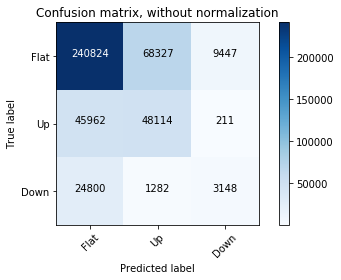

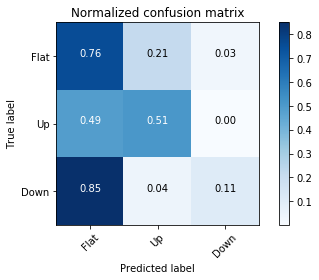

In [40]:
#Оцениваем качество разметки по файлу mappedSubAllChangePoints (если в него залито Clean, то сравниваются усредненные эксперты)
#Для усредненных данных сохраняем еще confusion matrix
if (mode =="OUT") and (clean==True):
    TF_names = ['Flat', 'Up',"Down"]
    TF_labels=[0,1,-1]
    y_TF_cl=mappedSubAllChangePoints.dropna()["NewTypeBool_Avg"]
    y_TF_pred_cl=mappedSubAllChangePoints.dropna()["ScoredNewTypeBool"]
    cm, cm_norm=show_cnf_matrix(y_TF_cl, y_TF_pred_cl,TF_names,TF_labels)
    
    if test_only==False:
        TF_train_cl=mappedSubAllChangePoints[mappedSubAllChangePoints["Date"]<=d_split]
        TF_test_cl=mappedSubAllChangePoints[mappedSubAllChangePoints["Date"]>d_split]
        
        TF_train_cl.dropna(inplace=True)
        TF_test_cl.dropna(inplace=True)
        y_TF_train_cl=TF_train_cl["NewTypeBool_Avg"]
        y_TF_test_cl=TF_test_cl["NewTypeBool_Avg"]
        y_TF_train_pred_cl=TF_train_cl["ScoredNewTypeBool"]
        y_TF_test_pred_cl=TF_test_cl["ScoredNewTypeBool"]
        cm_t, cm_t_norm=show_cnf_matrix(y_TF_train_cl, y_TF_train_pred_cl,TF_names,TF_labels)
        cm_v, cm_v_norm=show_cnf_matrix(y_TF_test_cl, y_TF_test_pred_cl,TF_names,TF_labels)

In [ ]:
#считаем дополнительные метрики по всем данным
if mode =="OUT":
    key=["Source","Stockname","Date"]
    mappedNewAllChangePoints["Date"]=pd.to_datetime(mappedNewAllChangePoints["Date"], format = "%Y/%m/%d")
    sortedNewAllChangePoints = mappedNewAllChangePoints.sort_values(by=key).dropna()
    y_pipe_sort=abs(sortedNewAllChangePoints["NewTypeBool_sign"])
    y_pipe_pred_sort=abs(sortedNewAllChangePoints["ScoredNewTypeBool"])
    # считаем новую метрику по всем данным
    pipe_f=trd.freq(y_pipe_sort.as_matrix().flatten(), y_pipe_pred_sort.as_matrix().flatten())
    # считаем другую новую метрику
    pipe_d= trd.delay(y_pipe_sort,y_pipe_pred_sort)
    print ("freq="+str(pipe_f))
    print ("delay="+str(pipe_d))

In [41]:
#считаем дополнительные метрики по усредненным данным (если залито Clean, то сравниваются усредненные эксперты))
if (mode =="OUT") and (clean==True): 
    key=["Source","Stockname","Date"]
    mappedSubAllChangePoints["Date"]=pd.to_datetime(mappedSubAllChangePoints["Date"], format = "%Y/%m/%d")
    sortedSubAllChangePoints = mappedSubAllChangePoints.sort_values(by=key).dropna()
    y_pipe_sort_cl=abs(sortedSubAllChangePoints["NewTypeBool_Avg"])
    y_pipe_pred_sort_cl=abs(sortedSubAllChangePoints["ScoredNewTypeBool"])
    # считаем новую метрику по усредненным данным
    pipe_f_cl=trd.freq(y_pipe_sort_cl.as_matrix().flatten(), y_pipe_pred_cl.as_matrix().flatten())
    # считаем другую новую метрику по усредненным данным
    pipe_d_cl=trd.delay(y_pipe_sort_cl,y_pipe_pred_sort_cl)
    print ("freq="+str(pipe_f_cl))
    print ("delay="+str(pipe_d_cl))

freq=-0.8176724137931034
delay=0.11492484986937787


In [ ]:
#сохраняем статистику качества (только для размеченных данных)
if mode =="OUT":
    Pipe_address= os.path.join(path, pipe_file_name+"_stats.txt")
    if test_only==False:
        trd.save_results(Pipe_address,pipe_rep_t,pipe_acc_t,pipe_auc_t,pipe_rep_v,pipe_acc_v,pipe_auc_v)
    Pipeline_stats= open(Pipe_address,"a")
    text1='\n'+ "Full_set"+'\n'+ pipe_rep_f +'\n'+ "Accuracy: %.2f%%" % (pipe_acc_f * 100.0)+ '\n'+"AUC: %.2f%%" % (pipe_auc_f * 100.0)
    text2='\n'+ "Full_set"+'\n'+ "Freq: %.2f%%" % (pipe_f * 100.0)+ '\n'+"Delay: %.2f%%"% (pipe_d * 100.0) 
    Pipeline_stats.write(text1+'\n'+text2)
    Pipeline_stats.close()

In [42]:
#сохраняем статистику качества (только для размеченных данных) - усредненные эксперты
#Дополнительно сохраняется confusion_matrix
if (mode =="OUT") and (clean==True):
    Pipe_address_cl= os.path.join(path, pipe_file_name+"_sub_stats.txt")
    if test_only==False:
        trd.save_results(Pipe_address_cl,pipe_rep_t_cl,pipe_acc_t_cl,pipe_auc_t_cl,str(cm_t), str(cm_t_norm), pipe_rep_v_cl,pipe_acc_v_cl,pipe_auc_v_cl, str(cm_v), str(cm_v_norm))
    Pipeline_stats= open(Pipe_address_cl,"a")
    text1='\n'+ "Full_set"+'\n'+ pipe_rep_f_cl +'\n'+ "Accuracy: %.2f%%" % (pipe_acc_f_cl * 100.0)+ '\n'+"AUC: %.2f%%" % (pipe_auc_f_cl * 100.0)
    text2='\n'+ "Full_set"+'\n'+ "Freq: %.2f%%" % (pipe_f_cl * 100.0)+ '\n'+"Delay: %.2f%%"% (pipe_d_cl* 100.0)
    text3='\n'+ "Full_set"+'\n'+ "Confusion matrix "+ str(cm) +'\n' +"Normalized confusion matrix "+ str(cm_norm)
    Pipeline_stats.write(text1+'\n'+text2+ '\n'+ text3)
    Pipeline_stats.close()

## 5. Визуализация

Визуализация может работать как в связке с предыдущими пунктами, так и независимо от них (режим регулируется переменной use_current)

In [ ]:
import plotly as py
from datetime import timedelta
use_current=True##указывает, следует ли использовать настройки, полученные при последнем прогоне Ipython notebook 
if use_current==False:
    #если используются не текущие настройки, то надо указать какие именно
    path = os.path.join('/Users', 'KatieHome', 'Desktop', 'FinUniversity','Alpha-project','Alfa-Capital','Logs_moved')
    mode="OUT"
    logarithm=True
    #title="Pipeline_OUT_ChP24_TF11_ln_clean_up_to_13-10-2014tresh=0.6_ln_121017"
    #title="Pipeline_OUT_ChP25_TF12_ln_cleantresh=0.6_ln_060617"
    #title="Pipeline_OUT_ChP25_TF12_ln_clean_up_to_6-11-2014tresh=0.6_ln_121017"
    #title="Pipeline_IN_ChP23_TF10_ln__tresh=0.6IN"
    #pipe_file_name="Pipeline_OUT_ChP26_TF11_ln_clean_up_to_13-10-2014_tresh=0.85_ln_121017v2"
    pipe_file_name="Pipeline_OUT_ChP28_TF12_ln_clean_up_to_6-11-2014_tresh=0.5_ln_121017v2"
    mappedSubAllChangePoints=pd.read_csv(os.path.join(path, pipe_file_name+"__sub_results.csv"), header=0, sep=',',encoding='cp1251')
    mappedSubAllChangePoints["Date"] = pd.to_datetime(mappedSubAllChangePoints["Date"], format = "%Y/%m/%d")

In [ ]:
num_cols_orig=["Open_orig","High_orig","Low_orig","Close_orig", "Volume_orig"]
if logarithm: #для моделей, где использована разность логарифмов, а не частное
    mappedSubAllChangePoints[num_cols_orig]=np.exp(mappedSubAllChangePoints[["Open","High","Low","Close","Volume"]])
else:    
    mappedSubAllChangePoints[num_cols_orig]=mappedSubAllChangePoints["Open","High","Low","Close", "Volume"]
    

In [ ]:
relevant_cols=["Date","Stockname"]
relevant_cols.extend(num_cols)
relevant_cols.extend(['ScoredNewTrigger_tmp',
                       'ScoredNewTypeBool',
                       'ScoredNewTrigger',
                       'ScoredNewIDselect'])
if mode=="OUT": relevant_cols.extend(['NewTypeBool_Avg','NewTrigger_Avg'])

In [ ]:
mappedSubAllChangePoints.dropna(subset=relevant_cols,inplace=True)

In [ ]:
# Поскольку эксперт не разделял тренды на восходящие и нисходящие,
# то и на графике будет два типа истинных значения: тренд или флэт
if mode=="OUT":
    mappedSubAllChangePoints.loc[mappedSubAllChangePoints['NewTypeBool_Avg'] == -1, 'NewTypeBool_Avg'] = 1

In [ ]:
# Строится отдельный график для каждой акции
allstocks=list(mappedSubAllChangePoints['Stockname'].drop_duplicates())
bar = pbar.ProgressBar(max_value=len(allstocks)).start() # Создаём новый progress bar
t=0
for stock_name in allstocks:
    # Выбираются из всех данных только данные по одной акции
    stock_data = mappedSubAllChangePoints[mappedSubAllChangePoints['Stockname'] == stock_name].copy()
    # Сортировка всех данных по дате
    stock_data.sort_values('Date', ascending=True, inplace=True)
    
    # Название акции без технических слов/символов
    name = stock_name.split(' ')[0].split('_')[0]
    
    # Линия акции
    trace_stock = py.graph_objs.Candlestick(x=stock_data['Date'],
                                            open=stock_data['Open_orig'] ,
                                            high=stock_data['High_orig'] ,
                                            low=stock_data['Low_orig'],
                                            close=stock_data['Close_orig'],
                                            name=name)
    
    # Линия объема акции
    trace_volume = py.graph_objs.Scatter(x=stock_data['Date'],
                                         y=stock_data['Volume_orig'],
                                         mode='lines',
                                         name='Volume',
                                         line=dict(color='#7C2209',
                                                   width=3),
                                         yaxis='y2')
    # В случае режима работы с размеченными данными создается фоновая подложка истинных значений тренд/флэт
    if mode=="OUT":
        stock_data['tmp'] = stock_data['NewTypeBool_Avg'].diff()
        stock_data.set_value(stock_data.index[0], 'tmp', 1)
        stock_data.set_value(stock_data.index[-1], 'tmp', 1)
    
        trend_first = stock_data.loc[stock_data.index[0], 'NewTypeBool_Avg'] == 1
    color_trend = '#54d88c'  # Цвет восходящего тренда
    color_flat = '#ff4633'  # Цвет нисходящего тренда
    
    if mode=="OUT":
        dates = stock_data['Date'][stock_data['tmp'] != 0]
        shapes = [{'type': 'rect',
                        'xref': 'x',
                        'yref': 'paper',
                        'x0': i - timedelta(days=1),
                        'y0': 0,
                        'x1': j - timedelta(days=1),
                        'y1': 1,
                        'fillcolor': color_trend if trend_first else color_flat,
                        'opacity': 0.25,
                        'line': dict(width=0)} for i, j in zip(dates[::2], dates[1::2])]

        shapes.extend([{'type': 'rect',
                             'xref': 'x',
                             'yref': 'paper',
                             'x0': i - timedelta(days=1),
                             'y0': 0,
                             'x1': j - timedelta(days=1),
                             'y1': 1,
                             'fillcolor': color_flat if trend_first else color_trend,
                             'opacity': 0.25,
                             'line': dict(width=0)} for i, j in zip(dates[1::2], dates[2::2])])

        # Фиктивная (невидимая) точка для создания элемента легенды,
        # отвечающего за истинное значение флэта, размеченного экспертом
        # (подложка не создает элемент легенды)
        trace_flat_expert = py.graph_objs.Scatter(x=[stock_data['Date'][stock_data.index[0]]],
                                                      y=[stock_data['Close_orig'][stock_data.index[0]]],
                                                       hoverinfo='none',
                                                       visible='legendonly',
                                                       name='Flat - Ground Truth',
                                                       mode='markers',
                                                       marker=dict(size=20,
                                                                   color='#ff4633',
                                                                   opacity=0.25,
                                                                   symbol='square',
                                                                   line = dict(width=0)))

        # Фиктивная (невидимая) точка для создания элемента легенды,
        # отвечающего за истинное значение тренда, размеченного экспертом
        # (подложка не создает элемент легенды)
        trace_trend_expert = py.graph_objs.Scatter(x=[stock_data['Date'][stock_data.index[0]]],
                                                        y=[stock_data['Close_orig'][stock_data.index[0]]],
                                                        hoverinfo='none',
                                                        visible='legendonly',
                                                        name='Trend - Ground Truth',
                                                        mode='markers',
                                                        marker=dict(size=20,
                                                                    color='#54d88c',
                                                                    opacity=0.25,
                                                                    symbol='square',
                                                                    line = dict(width=0)))

        # Вертикальные черные штриховые линии, обозначающие точки перегиба, отмеченные экспертом
        cp_gt = [py.graph_objs.Scatter(x=[dt, dt],
                                            y=[trace_stock['low'].min(), trace_stock['high'].max()],
                                            mode='lines',
                                            legendgroup='ChangePointsGT',
                                            showlegend=False,
                                            hoverinfo='none',
                                            line=dict(dash='dash',
                                                      width=1,
                                                      color='black')) for dt in stock_data['Date'][stock_data['NewTrigger_Avg'] == 1]]
        if cp_gt:
            cp_gt[0]['showlegend'] = True
            cp_gt[0]['name'] = 'ChangePoints - Ground truth'

        stock_data.dropna(subset=['ScoredNewTrigger_tmp',
                                       'ScoredNewTypeBool',
                                       'ScoredNewTrigger',
                                       'ScoredNewIDselect'], inplace=True)

    stock_data.reset_index(drop=True, inplace=True)
        
    # Вертикальные черные сплошные линии, обозначающие точки перегиба, отмеченные моделью
    cp_model = [py.graph_objs.Scatter(x=[dt, dt],
                                      y=[trace_stock['low'].min(), trace_stock['high'].max()],
                                      mode='lines',
                                      legendgroup='ChangePointsModel',
                                      showlegend=False,
                                      hoverinfo='none',
                                      line=dict(width=1,
                                                color='black')) for dt in stock_data['Date'][stock_data['ScoredNewTrigger'] == 1]]
    if cp_model:
        cp_model[0]['showlegend'] = True
        cp_model[0]['name'] = 'ChangePoints - Model'
        
    # Вертикальные красные штриховые линии, обозначающие точки,
    # в которых модель получила сигнал (гипотетические точки перегиба)
    cp_signal = [py.graph_objs.Scatter(x=[dt, dt],
                                       y=[trace_stock['low'].min(), trace_stock['high'].max()],
                                       mode='lines',
                                       legendgroup='ChangePointsSignal',
                                       showlegend=False,
                                       hoverinfo='none',
                                       line=dict(dash='dash',
                                                 width=1,
                                                 color='red')) for dt in stock_data['Date'][stock_data['ScoredNewTrigger_tmp'] == 1]]
    if cp_signal:
        cp_signal[0]['showlegend'] = True
        cp_signal[0]['name'] = 'ChangePoints - Signal'

    # Создаются три массива дат, в которых модель видит: -1: нисходящий тренд,
    #                                                     0: флэт,
    #                                                     1: восходящий тренд
    stock_data.loc[stock_data.index[-1], 'ScoredNewTypeBool'] = -3
    prev_phase = stock_data.loc[stock_data.index[0], 'ScoredNewTypeBool']
    start = stock_data.index[0]
    phases = {-1:[], 0:[], 1:[]}
    for row_id, _ in stock_data.iterrows():
        cur_phase = stock_data.loc[row_id, 'ScoredNewTypeBool']
        if cur_phase != prev_phase:
            phases[prev_phase].append((stock_data.loc[start, 'Date'], stock_data.loc[row_id, 'Date']))
            start = row_id
        prev_phase = cur_phase
    
    colors = {-1: color_flat, 0: '#3f51b5', 1: color_trend}
    yys = {-1: trace_stock['high'].max(), 0: trace_stock['low'].min(), 1: trace_stock['high'].max()}
    names = {-1: 'Decreasing Trend', 0: 'Flat', 1: 'Increasing Trend'}

    # Линия нисходящих трендов, размеченных моделью
    trace_trend_dec = [py.graph_objs.Scatter(x=[i, j],
                                             y=[yys[-1],
                                                yys[-1]],
                                             legendgroup='TrendOrFlatModel1',
                                             showlegend=False,
                                             hoverinfo='none',
                                             mode='lines',
                                             line=dict(color=colors[-1],
                                                       width=5)) for i, j in phases[-1]]
    if trace_trend_dec:
        trace_trend_dec[0]['showlegend'] = True
        trace_trend_dec[0]['name'] = '{0} - Model'.format(names[-1])
        
    # Линия восходящих трендов, размеченных моделью
    trace_trend_inc = [py.graph_objs.Scatter(x=[i, j],
                                             y=[yys[1],
                                                yys[1]],
                                             legendgroup='TrendOrFlatModel2',
                                             showlegend=False,
                                             hoverinfo='none',
                                             mode='lines',
                                             line=dict(color=colors[1],
                                                       width=5)) for i, j in phases[1]]
    
    if trace_trend_inc:
        trace_trend_inc[0]['showlegend'] = True
        trace_trend_inc[0]['name'] = '{0} - Model'.format(names[1])
        
    # Линия флэтов, размеченных моделью
    trace_flat = [py.graph_objs.Scatter(x=[i, j],
                                        y=[yys[0],
                                           yys[0]],
                                        legendgroup='TrendOrFlatModel3',
                                        showlegend=False,
                                        hoverinfo='none',
                                        mode='lines',
                                        line=dict(color=colors[0],
                                                  width=5)) for i, j in phases[0]]
    
    if trace_flat:
        trace_flat[0]['showlegend'] = True
        trace_flat[0]['name'] = '{0} - Model'.format(names[0])
    
    # Случай режима работы с размеченными данными (данные содержат разметку эксперта)
    if mode=="OUT":
        
        # Все линии, относящиеся к разметке, произведенной экспертом и моделью помещаются в массив
        data = py.graph_objs.Data([trace_stock,
                               trace_volume,
                               *cp_gt,
                               *cp_model,
                               *cp_signal,
                               trace_flat_expert,
                               trace_trend_expert,
                               *trace_trend_dec,
                               *trace_trend_inc,
                               *trace_flat])

        # Создается объект фона графика, на котором присутствует фоновая подложка истинных значений тренд/флэт
        layout = py.graph_objs.Layout(title=name,
                                  xaxis=dict(autorange=True,
                                             rangeslider=dict(visible=False)),
                                  yaxis2=dict(overlaying='y',
                                              side='right',
                                              zeroline=False,
                                              showgrid=False,),
                                  autosize=True,
                                  shapes=shapes)

    # Случай режима работы без наличия истинной разметки эксперта
    else:
        # Все линии, относящиеся к разметке, произведенной только моделью помещаются в массив
        data = py.graph_objs.Data([trace_stock,
                               trace_volume,
                               #*cp_gt,
                               *cp_model,
                               *cp_signal,
                               #trace_flat_expert,
                               #trace_trend_expert,
                               *trace_trend_dec,
                               *trace_trend_inc,
                               *trace_flat])

        # Создается объект фона графика, на котором отсутствует фоновая подложка истинных значений тренд/флэт
        layout = py.graph_objs.Layout(title=name,
                                  xaxis=dict(autorange=True,
                                             rangeslider=dict(visible=False)),
                                  yaxis2=dict(overlaying='y',
                                              side='right',
                                              zeroline=False,
                                              showgrid=False,),
                                  autosize=True)#,
                                  #shapes=shapes)
            
    # Все необходимые линии наносятся на график, а также отрисовывается фон
    fig = py.graph_objs.Figure(data=data, layout=layout)

    # График сохраняется в формате html в папку "Pictures" и имеет название соответствующей акции
    py.offline.plot(fig, auto_open=False, filename=os.path.join(path,"Pictures",pipe_file_name+'_{0}.html').format(name))
    t+=1
    bar.update(t)
bar.finish()